<a href="https://colab.research.google.com/github/fahadshakeel23/DataScience/blob/main/HealthCare_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import shap
import matplotlib.pyplot as plt

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00451/dataR2.csv'

In [6]:
df = pd.read_csv(url)

In [7]:
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB


In [9]:
df.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000,1.551724
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663,0.499475
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000,1.000000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250,1.000000
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500,2.000000
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000,2.000000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000,2.000000


In [14]:
df['Classification'].value_counts(normalize=True)

,proportion
Classification,
2,0.551724
1,0.448276


Section 2: Data Cleaning & Preprocessing

In [16]:
df.isnull().sum()

,0
Age,0
BMI,0
Glucose,0
Insulin,0
HOMA,0
Leptin,0
Adiponectin,0
Resistin,0
MCP.1,0
Classification,0


In [18]:
X = df.drop('Classification', axis=1)
y = df['Classification']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_scaled.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,-0.579794,-0.816675,-1.239222,-0.728739,-0.614282,-0.932334,-0.070222,-0.545517,-0.341251
1,1.601821,-1.378751,-0.258299,-0.688038,-0.548240,-0.930413,-0.697350,-0.864214,-0.191224
2,1.539489,-0.891764,-0.302887,-0.550073,-0.464752,-0.454219,1.797998,-0.441660,0.058214
3,0.666843,-1.243303,-0.927110,-0.676965,-0.574210,-0.876021,-0.441945,-0.158867,1.142718
4,1.788816,-1.294601,-0.258299,-0.644743,-0.521081,-1.042682,-0.786881,-0.336352,0.694716


 Feature Engineering & Selection

In [22]:
selector = SelectKBest(score_func=f_classif, k=7)
X_selected = selector.fit_transform(X_scaled, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

Selected Features: ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Resistin', 'MCP.1']


Predictive Modeling

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify = y, random_state=42)

# random Forest
rf= RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Random forest classification report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))

#Logistic regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Random forest classification report:
              precision    recall  f1-score   support

           1       0.79      0.85      0.81        13
           2       0.87      0.81      0.84        16

    accuracy                           0.83        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.83      0.83      0.83        29

ROC AUC: 0.8822115384615384
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.85      0.76        13
           2       0.85      0.69      0.76        16

    accuracy                           0.76        29
   macro avg       0.77      0.77      0.76        29
weighted avg       0.78      0.76      0.76        29

ROC AUC: 0.8173076923076923


Interpretability & Explainability



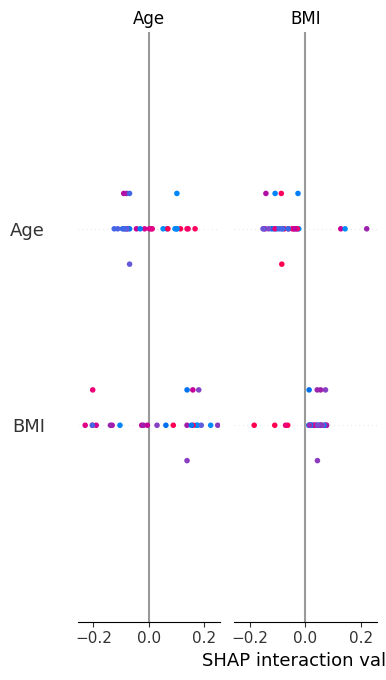

In [26]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=selected_features)


Reporting & Recommendations

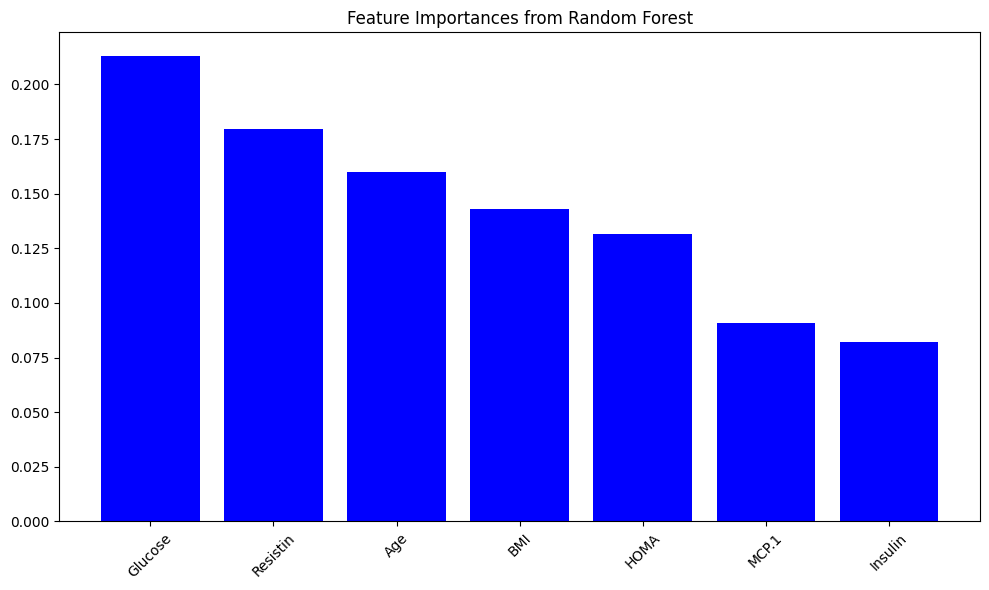

In [27]:

importances = rf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances from Random Forest")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), selected_features[indices], rotation=45)
plt.tight_layout()
plt.show()
